### Implementing a CNN for Human Activity Recognition in Tensorflow

modified from:
https://aqibsaeed.github.io/2016-11-04-human-activity-recognition-cnn/

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
# plt.style.use('ggplot')

In [47]:
# replace ";" with "\n" in raw data
PATH_DATA = "./WISDM_ar_v1.1/"
RAW_DATA = "WISDM_ar_v1.1_raw.txt"
NEW_DATA = "WISDM_ar_v1.1_new.txt"

f = open(PATH_DATA + RAW_DATA)
g = open(PATH_DATA + NEW_DATA, "w")
g.write(f.read().replace(";", "\n"))
f.close()
g.close()

In [48]:
COLUMN_NAMES = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv(PATH_DATA + NEW_DATA, header = None, names = COLUMN_NAMES)

print("shape: \n", df.shape, "\n")
print("heads: \n", df.head(), "\n")
print("dtypes: \n", df.dtypes, "\n")
print("description: \n", df.describe(), "\n")

shape: 
 (1098209, 6) 

heads: 
    user-id activity       timestamp    x-axis     y-axis    z-axis
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164 

dtypes: 
 user-id        int64
activity      object
timestamp      int64
x-axis       float64
y-axis       float64
z-axis       float64
dtype: object 

description: 
             user-id     timestamp        x-axis        y-axis        z-axis
count  1.098209e+06  1.098209e+06  1.098209e+06  1.098209e+06  1.098208e+06
mean   1.886067e+01  3.340892e+13  6.628694e-01  7.255624e+00  4.110784e-01
std    1.021423e+01  4.944961e+13  6.849044e+00  6.746214e+00  4.754120e+00
min    1.000000e+00  0.000000e+00 -1.961000e+01 -1.961000e+01 -1.980000e+01
25%    1.000000e

In [49]:
def feature_normalize(values):
    mu = np.mean(values, axis = 0)
    sigma = np.std(values, axis = 0)
    return (values - mu)/sigma

In [50]:
df['x-axis'] = feature_normalize(df['x-axis'])
df['y-axis'] = feature_normalize(df['y-axis'])
df['z-axis'] = feature_normalize(df['z-axis'])

print("description: \n", df.describe(), "\n")

description: 
             user-id     timestamp        x-axis        y-axis        z-axis
count  1.098209e+06  1.098209e+06  1.098209e+06  1.098209e+06  1.098208e+06
mean   1.886067e+01  3.340892e+13  2.108010e-14  7.017430e-13  2.629483e-14
std    1.021423e+01  4.944961e+13  1.000000e+00  1.000000e+00  1.000000e+00
min    1.000000e+00  0.000000e+00 -2.959957e+00 -3.982328e+00 -4.251279e+00
25%    1.000000e+01  2.019102e+12 -5.158196e-01 -6.056175e-01 -5.534315e-01
50%    1.900000e+01  9.722652e+12 -5.736123e-02  9.996374e-02 -8.646787e-02
75%    2.800000e+01  4.996557e+13  5.514831e-01  6.380436e-01  4.856677e-01
max    3.600000e+01  2.093974e+14  2.816034e+00  1.895046e+00  4.038377e+00 



In [51]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

In [52]:
np.unique(df["activity"])

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

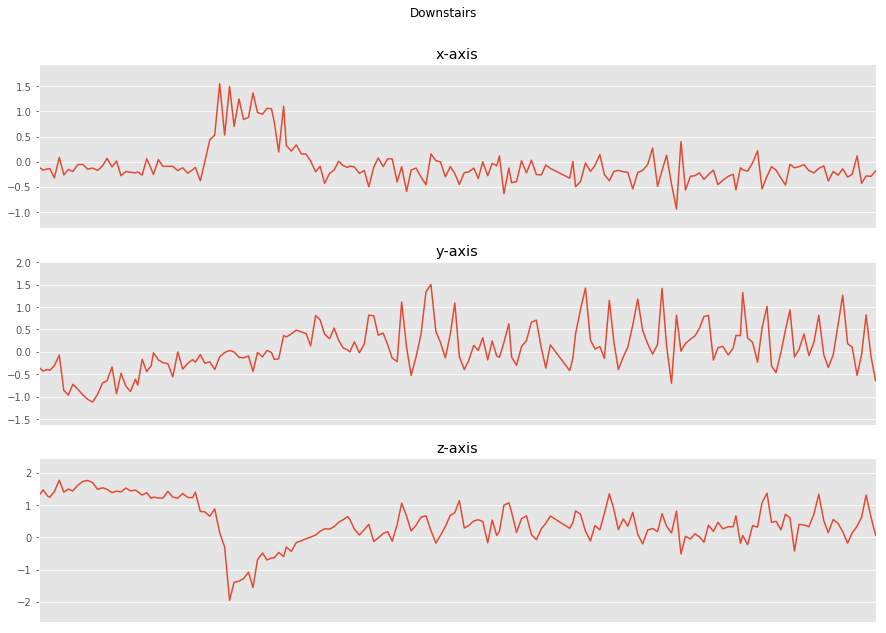

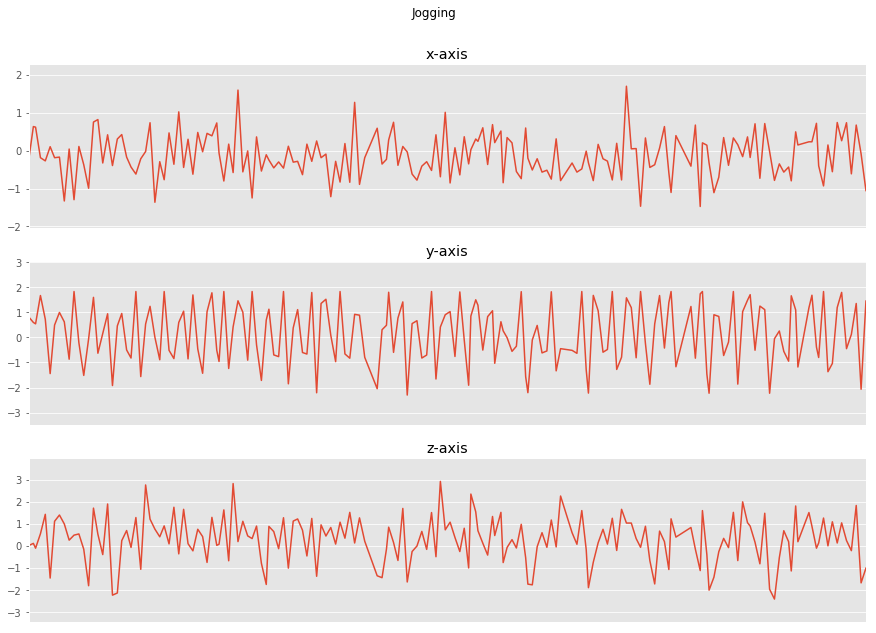

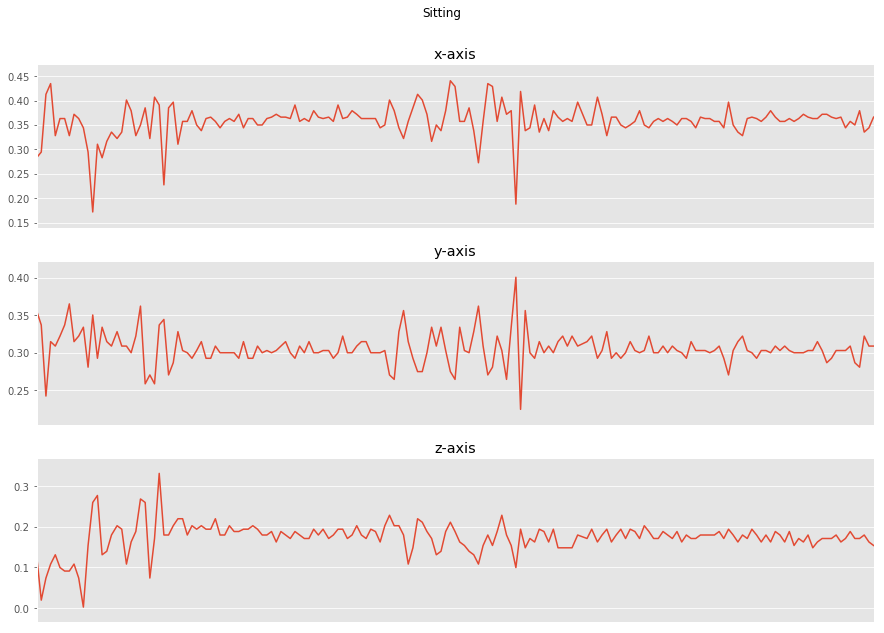

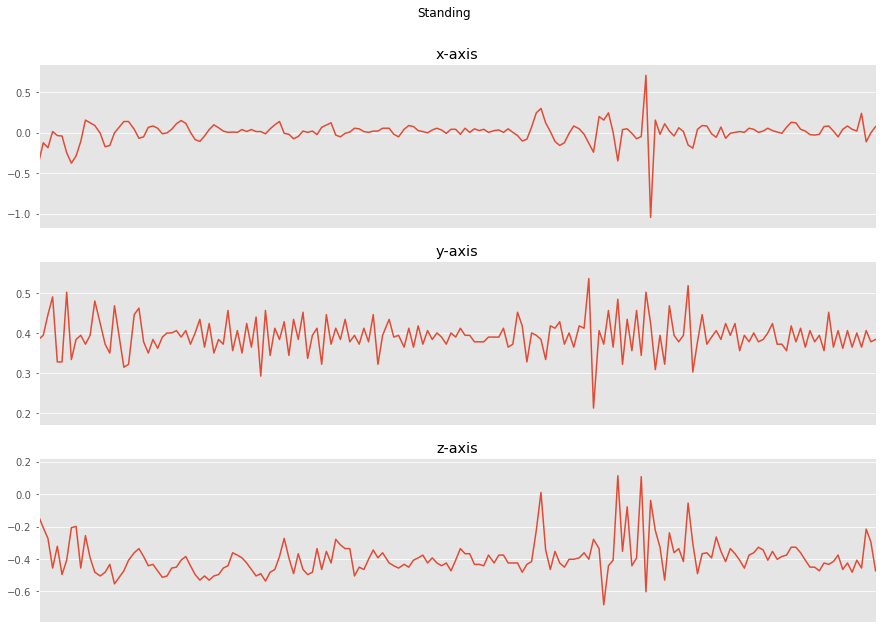

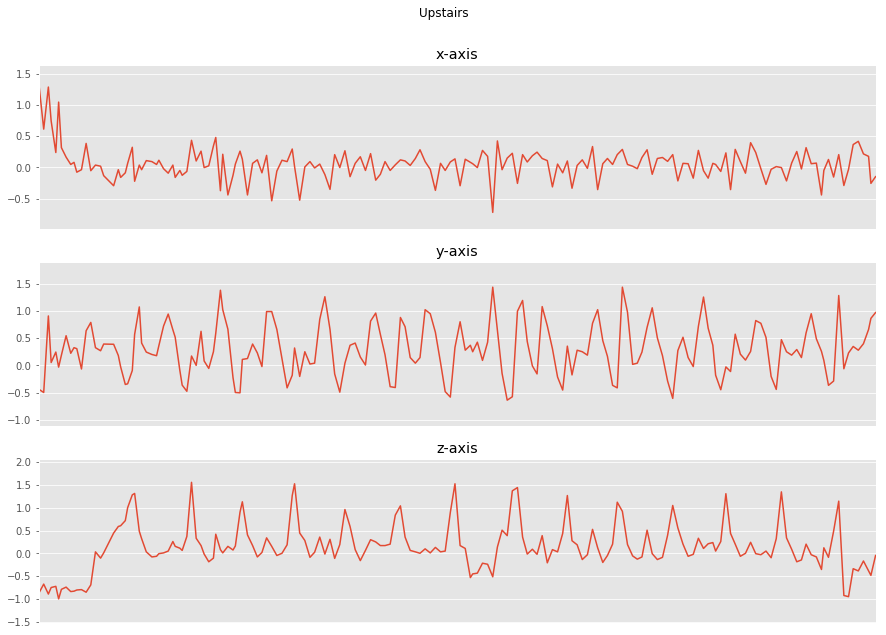

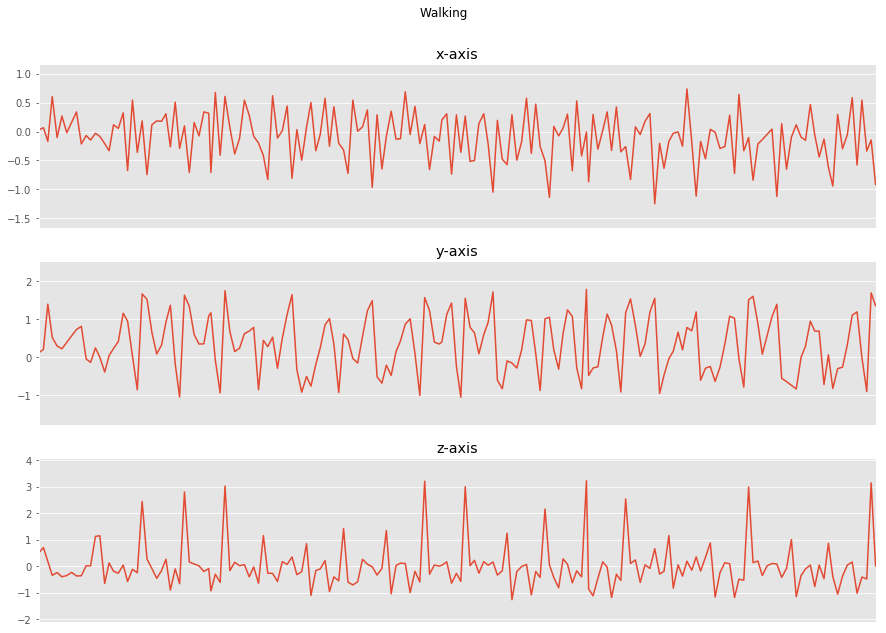

In [56]:
for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36]


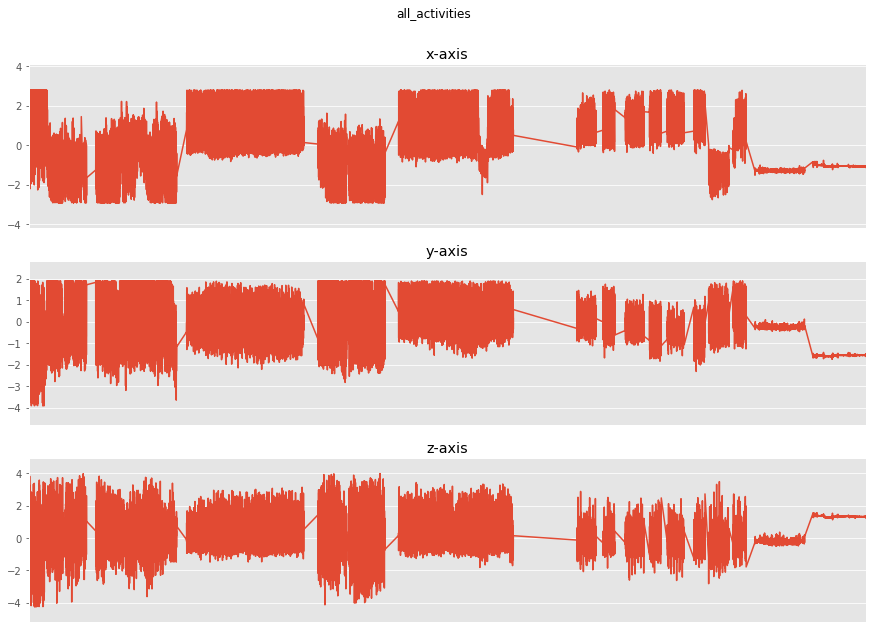

In [71]:
print(np.unique(df["user-id"]))
plot_activity("all_activities", df[df["user-id"] == 7][:])

In [76]:
def windows(data, size):
    start = 0
    while start < data.count():
        yield start, start + size
        start += 45
#         start += (size / 2)
        
def segment_signal(data, window_size = 90):
    segments = np.empty((0, window_size, 3))
    labels = np.empty((0))
    for (start, end) in windows(data["timestamp"], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset["timestamp"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

In [77]:
segments, labels = segment_signal(df)

/Users/youngmin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [86]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1, 90, 3)

In [89]:
print(segments.shape)
print(reshaped_segments.shape)
print(labels.shape)

(24403, 90, 3)
(24403, 1, 90, 3)
(24403, 6)


In [112]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

![title](https://aqibsaeed.github.io/img/har-cnn.PNG)

In [113]:
input_height = 1
input_width = 90
num_labels = 6
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 5

total_batchs = segments.shape[0] // batch_size

In [114]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

In [115]:
def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x, W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x, kernel_size, num_channels, depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights), biases))
    
def apply_max_pool(x, kernel_size, stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [116]:
X = tf.placeholder(tf.float32, shape=[None, input_height, input_width, num_channels])
Y = tf.placeholder(tf.float32, shape=[None, num_labels])

In [117]:
c = apply_depthwise_conv(X, kernel_size, num_channels, depth)
p = apply_max_pool(c, 20, 2)
c = apply_depthwise_conv(p, 6, depth*num_channels, depth//10)

In [118]:
shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1), f_biases_l1))

In [119]:
out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [120]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [122]:
with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batchs):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",np.mean(cost_history)," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch:  0  Training Loss:  7.34793068564  Training Accuracy:  0.792749
Epoch:  1  Training Loss:  12.484523283  Training Accuracy:  0.813041
Epoch:  2  Training Loss:  16.8273044745  Training Accuracy:  0.835497
Epoch:  3  Training Loss:  20.6042771833  Training Accuracy:  0.854503
Epoch:  4  Training Loss:  23.9345344034  Training Accuracy:  0.868772
Testing Accuracy: 0.869232
